In [172]:
from pathlib import Path
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import pandas as pd
import numpy as np
import wandb
import torch
from torch import nn
import sys
sys.path.append(str(Path.cwd().parent))
from viz_utils import load_dfiv_model, predict_dfiv_model, load_dfiv_runs, create_combined_df, create_latex_df, convert_to_latex_table, save_latex_str
import plotly.express as px
from src.data.demand_design import psi, f

In [173]:

from IPython.display import display, HTML
import plotly
plotly.offline.init_notebook_mode(connected=True)

# The polling here is to ensure that plotly.js has already been loaded before
# setting display alignment in order to avoid a race condition.
display(HTML(
    '<script>'
        'var waitForPlotly = setInterval( function() {'
            'if( typeof(window.Plotly) !== "undefined" ){'
                'MathJax.Hub.Config({ SVG: { font: "STIX-Web" }, displayAlign: "center" });'
                'MathJax.Hub.Queue(["setRenderer", MathJax.Hub, "SVG"]);'
                'clearInterval(waitForPlotly);'
            '}}, 250 );'
    '</script>'
))

In [174]:
entity, project = "jasmineqy0", "formal_6"  

# Load Wandb Runs

In [175]:
group = 'dfiv_low_dim_parcs'
runs_df = load_dfiv_runs(entity, project, filters={'group' : group})

# Heteroscedasticity Visualization

In [176]:
num_point = 50000
function = 'original'

In [177]:
rng = np.random.default_rng(seed=0)

emotion = rng.choice(list(range(1, 8)), num_point)
time = rng.uniform(0, 10, num_point)
cost = rng.normal(0, 1.0, num_point)
rho = 0.5

noise_price = rng.normal(0, 1, num_point)
price = 25 + (cost + 3) * psi(function, time) + noise_price

In [178]:
phi = [0.1, 0.3, 0.5, 0.7, 0.9]
scaled_noise_price = 1 / (1 + np.exp(-noise_price))
hetero_noise_demand = [rng.normal(rho*noise_price, (1-scale**2)*scaled_noise_price, size=num_point) for scale in phi]
normal_noise_demand = [rng.normal(rho*noise_price, 1-scale**2, size=num_point) for scale in phi]

In [179]:
# normal_demand = f(price, time, emotion) + normal_noise_demand
# hetero_demand = [f(price, time, emotion) + noise for noise in hetero_noise_demand]

In [180]:
plt.rcParams.update({
    'font.size': 15
})

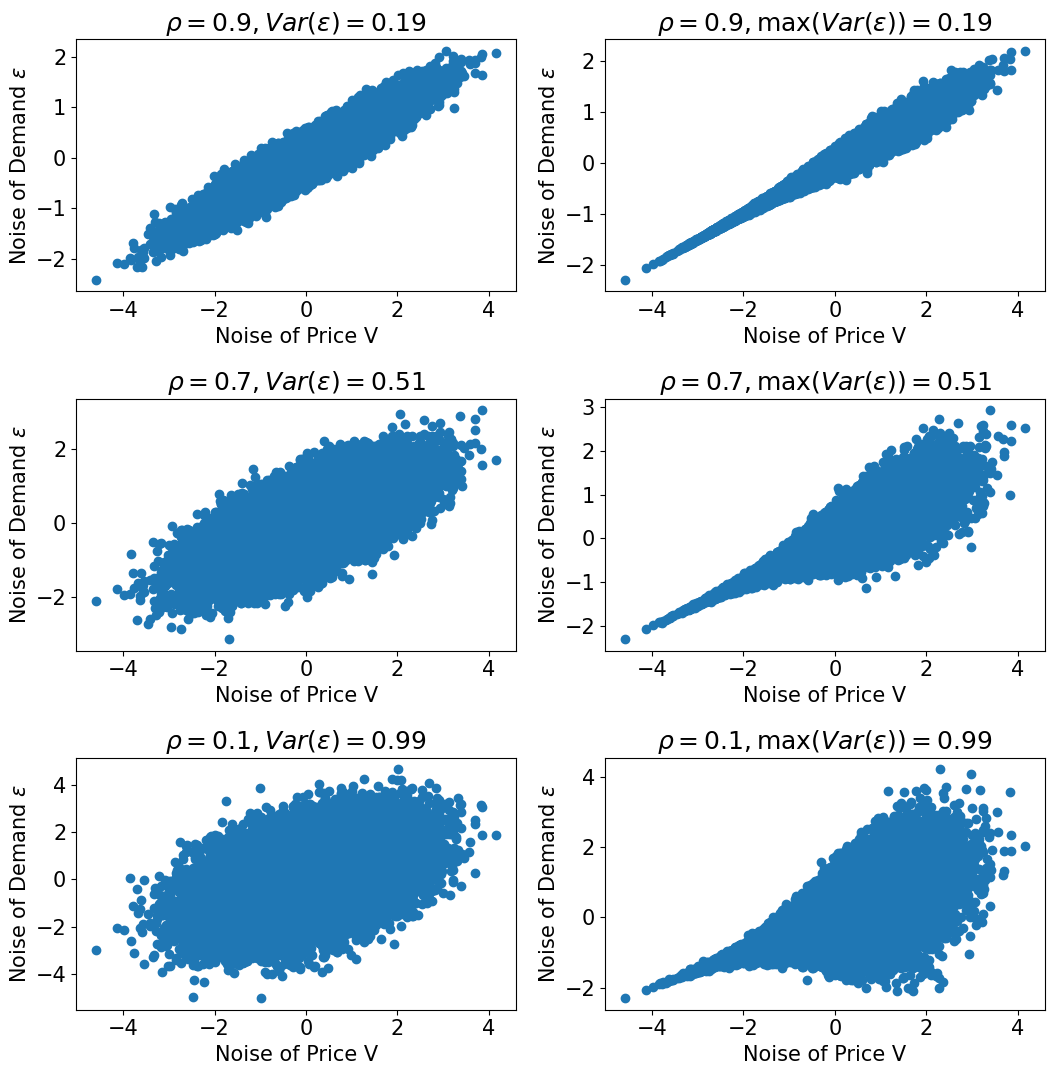

In [181]:
fig, axs = plt.subplots(3, 2, figsize=(11, 11))

axs[0, 0].scatter(noise_price, normal_noise_demand[-1])
axs[0, 0].set_title(r'$\rho=0.9, Var(\epsilon) = 0.19$')
axs[0, 0].set_xlabel('Noise of Price V')
axs[0, 0].set_ylabel('Noise of Demand $\epsilon$')

axs[0, 1].scatter(noise_price, hetero_noise_demand[-1])
axs[0, 1].set_title(r'$\rho=0.9, \max(Var(\epsilon)) = 0.19$')
axs[0, 1].set_xlabel('Noise of Price V')
axs[0, 1].set_ylabel('Noise of Demand $\epsilon$')

axs[1, 0].scatter(noise_price, normal_noise_demand[3])
axs[1, 0].set_title(r'$\rho=0.7, Var(\epsilon) = 0.51$')
axs[1, 0].set_xlabel('Noise of Price V')
axs[1, 0].set_ylabel('Noise of Demand $\epsilon$')

axs[1, 1].scatter(noise_price, hetero_noise_demand[3])
axs[1, 1].set_title(r'$\rho=0.7, \max(Var(\epsilon)) = 0.51$')
axs[1, 1].set_xlabel('Noise of Price V')
axs[1, 1].set_ylabel('Noise of Demand $\epsilon$')

axs[2, 0].scatter(noise_price, normal_noise_demand[0])
axs[2, 0].set_title(r'$\rho=0.1, Var(\epsilon) = 0.99$')
axs[2, 0].set_xlabel('Noise of Price V')
axs[2, 0].set_ylabel('Noise of Demand $\epsilon$')

axs[2, 1].scatter(noise_price, hetero_noise_demand[0])
axs[2, 1].set_title(r'$\rho=0.1, \max(Var(\epsilon))= 0.99$')
axs[2, 1].set_xlabel('Noise of Price V')
axs[2, 1].set_ylabel('Noise of Demand $\epsilon$')

plt.tight_layout()
fig.savefig(f'images/hetero_noise.png')

# Original

In [193]:
hetero = False
result_df = runs_df[runs_df['state'].apply(lambda x: x == 'finished')]
result_df = result_df[result_df['summary'].apply(lambda x: x['min_test_loss'] is not None)]
result_df = result_df[result_df['config'].apply(lambda x: x['data_configs']['function'] == function)]
result_df = result_df[result_df['config'].apply(lambda x: x['data_configs']['hetero'] == hetero)]
# runs_df = runs_df[runs_df['config'].apply(lambda x: x['data_configs']['data_size'] == 10000)]
print('Number of runs: ', len(result_df))

Number of runs:  150


In [194]:
grouped_df = result_df.groupby(result_df['config'].apply(lambda x: x['data_configs']['rho']))

original_rhos = []
original_mean_test_loss_list = []
original_std_test_loss_list = []
original_median_test_loss_list = []
original_test_loss_list = []
for group, group_df in grouped_df:
    n = len(group_df)
    print("Group:", group, 'Length:', n)
    
    original_rhos.append(group)
    
    test_loss_idx = group_df['summary'].apply(lambda x: True if 'min_test_loss' in x else False)
    test_loss_df = group_df[test_loss_idx]
    print('\t Number of runs with test loss: ', len(test_loss_df))

    original_test_loss = test_loss_df['summary'].apply(lambda x: x['min_test_loss'])
    original_test_loss_list.append(original_test_loss) 

    min_idx, min_test_loss = np.argmin(original_test_loss), np.min(original_test_loss)
    print(f"\t min test loss: {min_test_loss}")

    original_mean_test_loss = np.mean(original_test_loss)
    original_mean_test_loss_list.append(original_mean_test_loss)
    print('\t mean test loss: ', original_mean_test_loss)

    original_std_test_loss = np.std(original_test_loss)
    original_std_test_loss_list.append(original_std_test_loss)
    print('\t std test loss: ', original_std_test_loss)

    original_median_test_loss = np.median(original_test_loss)
    original_median_test_loss_list.append(original_median_test_loss)
    print('\tmedian test loss: ', original_median_test_loss)

Group: 0.1 Length: 30
	 Number of runs with test loss:  30
	 min test loss: 70.38099670410156
	 mean test loss:  117.58735631306966
	 std test loss:  21.36929194782617
	median test loss:  121.34973907470703
Group: 0.3 Length: 30
	 Number of runs with test loss:  30
	 min test loss: 44.4751091003418
	 mean test loss:  122.03447278340657
	 std test loss:  26.770078698607335
	median test loss:  125.65773391723633
Group: 0.5 Length: 30
	 Number of runs with test loss:  30
	 min test loss: 64.34732818603516
	 mean test loss:  119.03102696736654
	 std test loss:  26.260817148270036
	median test loss:  118.49087142944336
Group: 0.7 Length: 30
	 Number of runs with test loss:  30
	 min test loss: 68.8071060180664
	 mean test loss:  112.45997543334961
	 std test loss:  26.70630545222691
	median test loss:  108.66076278686523
Group: 0.9 Length: 30
	 Number of runs with test loss:  30
	 min test loss: 77.64884185791016
	 mean test loss:  107.05223922729492
	 std test loss:  20.985736674784572
	me

In [195]:
PM_SIGN = '±'
NUM_DECIMALS = 4
loss_col_name = 'MSE'

def create_combined_df(mean_df, std_df):
    combined_df = mean_df.copy()
    combined_df[loss_col_name] = combined_df[loss_col_name].astype(str)
    # combined_df['precision_correct_parents'] = combined_df['precision_correct_parents'].astype(str)
    # combined_df['recall_correct_parents'] = combined_df['recall_correct_parents'].astype(str)

    for std_row, mean_row in zip(std_df.iterrows(), mean_df.iterrows()):
        _, std_values = std_row
        mean_idx, mean_values = mean_row
        
        mean_mse, std_mse = f"{mean_values[loss_col_name]:.{NUM_DECIMALS}f}", f"{std_values[loss_col_name]:.{NUM_DECIMALS}f}"
        combined_df.at[mean_idx, loss_col_name] = f"{mean_mse} {PM_SIGN} {std_mse}"
        
        # mean_precision, std_precision = f"{mean_values['precision_correct_parents']:.{NUM_DECIMALS}f}", f"{std_values['precision_correct_parents']:.{NUM_DECIMALS}f}"
        # combined_df.at[mean_idx, 'precision_correct_parents'] = f"{mean_precision} {PM_SIGN} {std_precision}"
        
        # mean_recall, std_recall = f"{mean_values['recall_correct_parents']:.{NUM_DECIMALS}f}", f"{std_values['recall_correct_parents']:.{NUM_DECIMALS}f}"
        # combined_df.at[mean_idx, 'recall_correct_parents'] = f"{mean_recall} {PM_SIGN} {std_recall}"

    return combined_df

In [196]:
original_mean_df = pd.DataFrame({ 'rho': rhos,
                                  loss_col_name: original_mean_test_loss_list})
original_std_df = pd.DataFrame({  'rho': rhos,
                                  loss_col_name: original_std_test_loss_list})
original_combined_df = create_combined_df(original_mean_df, original_std_df)
original_combined_df

,rho,MSE
0,0.1,117.5874 ± 21.3693
1,0.3,122.0345 ± 26.7701
2,0.5,119.0310 ± 26.2608
3,0.7,112.4600 ± 26.7063
4,0.9,107.0522 ± 20.9857


# Hetero

In [197]:
hetero = True
result_df = runs_df[runs_df['state'].apply(lambda x: x == 'finished')]
result_df = result_df[result_df['summary'].apply(lambda x: x['min_test_loss'] is not None)]
result_df = result_df[result_df['config'].apply(lambda x: x['data_configs']['function'] == function)]
result_df = result_df[result_df['config'].apply(lambda x: x['data_configs']['hetero'] == hetero)]
print('Number of runs: ', len(result_df))

Number of runs:  150


In [198]:
grouped_df = result_df.groupby(result_df['config'].apply(lambda x: x['data_configs']['rho']))

hetero_rhos = []
hetero_mean_test_loss_list = []
hetero_std_test_loss_list = []
hetero_median_test_loss_list = []
hetero_test_loss_list = []
for group, group_df in grouped_df:
    n = len(group_df)
    print("Group:", group, 'Length:', n)
    
    hetero_rhos.append(group)
    
    test_loss_idx = group_df['summary'].apply(lambda x: True if 'min_test_loss' in x else False)
    test_loss_df = group_df[test_loss_idx]
    print('\t Number of runs with test loss: ', len(test_loss_df))

    hetero_test_loss = test_loss_df['summary'].apply(lambda x: x['min_test_loss'])
    hetero_test_loss_list.append(hetero_test_loss)

    min_idx, min_test_loss = np.argmin(hetero_test_loss), np.min(hetero_test_loss)
    print(f"\t min test loss: {min_test_loss}")

    hetero_mean_test_loss = np.mean(hetero_test_loss)
    hetero_mean_test_loss_list.append(hetero_mean_test_loss)
    print('\t mean test loss: ', hetero_mean_test_loss)

    hetero_std_test_loss = np.std(hetero_test_loss)
    hetero_std_test_loss_list.append(hetero_std_test_loss)
    print('\t std test loss: ', hetero_std_test_loss)

    hetero_median_test_loss = np.median(hetero_test_loss)
    hetero_median_test_loss_list.append(hetero_median_test_loss)
    print('\tmedian test loss: ', hetero_median_test_loss)

Group: 0.1 Length: 30
	 Number of runs with test loss:  30
	 min test loss: 72.45146942138672
	 mean test loss:  114.86697514851888
	 std test loss:  24.555715960938272
	median test loss:  114.94367599487305
Group: 0.3 Length: 30
	 Number of runs with test loss:  30
	 min test loss: 74.59619140625
	 mean test loss:  111.53446756998697
	 std test loss:  22.486192629008215
	median test loss:  112.64193344116212
Group: 0.5 Length: 30
	 Number of runs with test loss:  30
	 min test loss: 72.01012420654297
	 mean test loss:  111.11556472778321
	 std test loss:  19.929220091873088
	median test loss:  110.88290405273438
Group: 0.7 Length: 30
	 Number of runs with test loss:  30
	 min test loss: 74.46882629394531
	 mean test loss:  121.30636749267578
	 std test loss:  22.502544817600608
	median test loss:  119.68060684204102
Group: 0.9 Length: 30
	 Number of runs with test loss:  30
	 min test loss: 59.84276580810547
	 mean test loss:  121.11825586954753
	 std test loss:  26.378488441777513
	m

In [199]:
hetero_mean_df = pd.DataFrame({  'rho': hetero_rhos,
                                 loss_col_name: hetero_mean_test_loss_list})
hetero_std_df = pd.DataFrame({  'rho': hetero_rhos,
                                loss_col_name: hetero_std_test_loss_list})
hetero_combined_df = create_combined_df(hetero_mean_df, hetero_std_df)
hetero_combined_df

,rho,MSE
0,0.1,114.8670 ± 24.5557
1,0.3,111.5345 ± 22.4862
2,0.5,111.1156 ± 19.9292
3,0.7,121.3064 ± 22.5025
4,0.9,121.1183 ± 26.3785


In [200]:
multi_index_df = pd.concat([original_combined_df[loss_col_name], hetero_combined_df[loss_col_name]], axis=1, keys=['Homoscedastic', 'Heteroscedastic'])
multi_index_df.columns = pd.MultiIndex.from_product([[loss_col_name], multi_index_df.columns])
multi_index_df.insert(0, 'rho', original_combined_df['rho']) 
multi_index_df

rho                 MSE                    
             Homoscedastic     Heteroscedastic
0  0.1  117.5874 ± 21.3693  114.8670 ± 24.5557
1  0.3  122.0345 ± 26.7701  111.5345 ± 22.4862
2  0.5  119.0310 ± 26.2608  111.1156 ± 19.9292
3  0.7  112.4600 ± 26.7063  121.3064 ± 22.5025
4  0.9  107.0522 ± 20.9857  121.1183 ± 26.3785

In [201]:
original_lens = [len(test_loss) for test_loss in original_test_loss_list]
original_rhos = [[rho] * len for rho, len in zip(original_rhos, original_lens)]
original_rhos = list(chain(*original_rhos))
original_test_loss = list(chain(*original_test_loss_list))

hetero_lens = [len(test_loss) for test_loss in hetero_test_loss_list]
hetero_rhos = [[rho] * len for rho, len in zip(hetero_rhos, hetero_lens)]
hetero_rhos = list(chain(*hetero_rhos))
hetero_test_loss = list(chain(*hetero_test_loss_list))

In [202]:
viz_df = pd.DataFrame({ 'rho': original_rhos + hetero_rhos,
                        loss_col_name: original_test_loss + hetero_test_loss,
                        'type': ['Homoscedastic'] * len(original_test_loss) + ['Heteroscedastic'] * len(hetero_test_loss)})
viz_df

,rho,MSE,type
0,0.1,129.875595,Homoscedastic
1,0.1,155.732574,Homoscedastic
2,0.1,100.187172,Homoscedastic
3,0.1,125.211739,Homoscedastic
4,0.1,128.349548,Homoscedastic
...,...,...,...
295,0.9,139.821655,Heteroscedastic
296,0.9,108.362610,Heteroscedastic
297,0.9,115.245934,Heteroscedastic
298,0.9,59.842766,Heteroscedastic


In [203]:
fig = px.box(viz_df, x = 'rho', y = loss_col_name, color = 'type', points = 'all')
fig.show()

In [204]:
latex_str = convert_to_latex_table(multi_index_df)
save_latex_str(latex_str, f'hetero.tex')
print(latex_str)

\begin{tabular}{rll}
\toprule
 rho & \multicolumn{2}{l}{MSE} \\
     &      Homoscedastic &    Heteroscedastic \\
\midrule
0.10 & 117.5874 $\pm$ 21.3693 & 114.8670 $\pm$ 24.5557 \\
0.30 & 122.0345 $\pm$ 26.7701 & 111.5345 $\pm$ 22.4862 \\
0.50 & 119.0310 $\pm$ 26.2608 & 111.1156 $\pm$ 19.9292 \\
0.70 & 112.4600 $\pm$ 26.7063 & 121.3064 $\pm$ 22.5025 \\
0.90 & 107.0522 $\pm$ 20.9857 & 121.1183 $\pm$ 26.3785 \\
\bottomrule
\end{tabular}



# Stage 1

In [ ]:
# group = 'dfiv_low_dim_hetero_stage_1'
# runs_df = load_dfiv_runs(entity, project, filters={'group' : group})
# runs_df = runs_df[runs_df['state'].apply(lambda x: x == 'finished')]
# runs_df = runs_df[runs_df['config'].apply(lambda x: x['data_configs']['data_size'] == 10000)]

In [ ]:
# test_loss_idx = runs_df['summary'].apply(lambda x: True if 'test loss' in x else False)
# test_loss_df = runs_df[test_loss_idx]

# stage_1_test_loss = test_loss_df['summary'].apply(lambda x: x['test loss'])

# min_idx, min_test_loss = np.argmin(stage_1_test_loss), np.min(stage_1_test_loss)
# print(f"min test loss: {best_run['summary']['test loss']}\n")

# stage_1_mean_test_loss = np.mean(stage_1_test_loss)
# print('mean test loss: ', stage_1_mean_test_loss)

# stage_1_std_test_loss = np.std(stage_1_test_loss)
# print('std test loss: ', stage_1_std_test_loss)

In [ ]:
# best_run = runs_df.iloc[min_idx]
# assert best_run['summary']['test loss'] == min_test_loss, 'min test loss not equal to min test loss in test loss df'
# best_run_name, best_run_id = best_run['name'], best_run['id']
# print(f'best run name: {best_run_name}, best run id: {best_run_id}')

# run_path_stage_1 = '/'.join([entity, project, best_run_id])
# print(f'best run path: {run_path_stage_1}')

# dfiv_hetero_stage_1_model = load_dfiv_model(run_path_stage_1)

In [ ]:
# stage_1_test_sigma = test_loss_df['config'].apply(lambda x: x['data_configs']['sigma'])
# stage_1_test_rho = test_loss_df['config'].apply(lambda x: x['data_configs']['rho'])

# stage_1_sigma_seq = np.unique(np.sort(stage_1_test_sigma)).tolist()

# df_stage_1 = pd.DataFrame({'sigma': stage_1_test_sigma, 'rho': stage_1_test_rho, 'test loss': stage_1_test_loss})
# df_mean_stage_1 = df_stage_1.groupby(['sigma', 'rho']).mean().reset_index()
# df_mean_stage_1

In [ ]:
# fig = px.box(df_stage_1, x='sigma', y='test loss', title='Stage 1 Test Loss',
#              category_orders={'sigma':np.unique(np.sort(stage_1_test_sigma)).tolist(),})
# fig.update_xaxes(type='category')
# fig.show()

In [ ]:
# fig = px.bar(df_mean_stage_1, x='sigma', y='test loss', title='Stage 1 Mean Test Loss',
#              category_orders={'sigma':np.unique(np.sort(stage_1_test_sigma)).tolist(),})
# fig.update_xaxes(type='category')
# fig.show()

# Stage 2

In [ ]:
# group = 'dfiv_low_dim_hetero_stage_2_1'
# runs_df = load_dfiv_runs(entity, project, filters={'group' : group})
# print('Number of runs: ', len(runs_df))

In [ ]:
# runs_df = runs_df[runs_df['state'].apply(lambda x: x == 'finished')]
# runs_df = runs_df[runs_df['summary'].apply(lambda x: x['min_test_loss'] is not None)]
# # runs_df = runs_df[runs_df['config'].apply(lambda x: x['data_configs']['data_size'] == 10000)]
# print('Number of runs: ', len(runs_df))

In [ ]:
# grouped_df = runs_df.groupby(runs_df['config'].apply(lambda x: x['data_configs']['rho']))

# for group, group_df in grouped_df:
#     print("Group:", group)
    
#     test_loss_idx = group_df['summary'].apply(lambda x: True if 'min_test_loss' in x else False)
#     test_loss_df = group_df[test_loss_idx]
#     print('\tNumber of runs with test loss: ', len(test_loss_df))

#     original_test_loss = test_loss_df['summary'].apply(lambda x: x['min_test_loss'])

#     min_idx, min_test_loss = np.argmin(original_test_loss), np.min(original_test_loss)
#     print(f"\tmin test loss: {min_test_loss}")

#     original_mean_test_loss = np.mean(original_test_loss)
#     print('\tmean test loss: ', original_mean_test_loss)

#     original_std_test_loss = np.std(original_test_loss)
#     print('\tstd test loss: ', original_std_test_loss)

#     original_median_test_loss = np.median(original_test_loss)
#     print('\tmedian test loss: ', original_median_test_loss)

In [ ]:
# test_loss_idx = runs_df['summary'].apply(lambda x: True if 'test loss' in x else False)
# test_loss_df = runs_df[test_loss_idx]

# stage_2_test_loss = test_loss_df['summary'].apply(lambda x: x['min_test_loss'])

# min_idx, min_test_loss = np.argmin(stage_2_test_loss), np.min(stage_2_test_loss)
# print(f"min test loss: {best_run['summary']['min_test_loss']}\n")

# stage_2_mean_test_loss = np.mean(stage_2_test_loss)
# print('mean test loss: ', stage_2_mean_test_loss)

# stage_2_std_test_loss = np.std(stage_2_test_loss)
# print('std test loss: ', stage_2_std_test_loss)

In [ ]:
# best_run = runs_df.iloc[min_idx]
# assert best_run['summary']['min_test_loss'] == min_test_loss, 'min test loss not equal to min test loss in test loss df'
# best_run_name, best_run_id = best_run['name'], best_run['id']
# print(f'best run name: {best_run_name}, best run id: {best_run_id}')

# run_path_stage_2 = '/'.join([entity, project, best_run_id])
# print(f'best run path: {run_path_stage_2}')

# dfiv_hetero_stage_2_model = load_dfiv_model(run_path_stage_2)

In [ ]:
# stage_2_test_sigma = test_loss_df['config'].apply(lambda x: x['data_configs']['sigma'])
# stage_2_test_rho = test_loss_df['config'].apply(lambda x: x['data_configs']['rho'])

# stage_2_sigma_seq = np.unique(np.sort(stage_2_test_sigma)).tolist()

# df_stage_2 = pd.DataFrame({'sigma': stage_2_test_sigma, 'rho': stage_2_test_rho, 'test loss': stage_2_test_loss})
# df_mean_stage_2 = df_stage_2.groupby(['sigma', 'rho']).mean().reset_index()

In [ ]:
# fig = px.box(df_stage_2, x='sigma', y='test loss', title='Stage 2 Test Loss',
#              category_orders={'sigma':np.unique(np.sort(stage_1_test_sigma)).tolist(),})
# fig.update_xaxes(type='category')
# fig.show()

In [ ]:
# fig = px.bar(df_mean_stage_2, x='sigma', y='test loss', 
#              facet_col='rho', 
#              title='Stage 2 Mean Test Loss',
#              category_orders={'sigma':np.unique(np.sort(stage_2_test_sigma)).tolist(),})
# fig.update_xaxes(type='category')
# fig.show()

# CATE

In [ ]:
# num_point = 50

In [ ]:
# # vary t: fix p = 25, S = E[S]
# emotion_range = np.array([1, 2, 3, 4, 5, 6, 7])
# price_val = 25
# price = np.ones(num_point) * price_val
# time = np.linspace(0.0, 10, num_point)
# emotion = (np.ones(num_point) * np.mean(emotion_range))
# covariate = np.c_[time, emotion]

In [ ]:
# true_demand = f(price, time, emotion)

# price = price[:, np.newaxis]
# original_demand = predict_dfiv_model(dfiv_original_model, price, covariate)
# stage_1_pred_demand = predict_dfiv_model(dfiv_hetero_stage_1_model, price, covariate)
# stage_2_pred_demand = predict_dfiv_model(dfiv_hetero_stage_2_model, price, covariate)


In [ ]:
# fig, ax = plt.subplots()
# time = time.squeeze()
# l1 = ax.plot(time, true_demand, color='red', label='Truth')
# l2 = ax.plot(time, original_demand, color='blue', label='DFIV: original')
# l3 = ax.plot(time, stage_1_pred_demand, color='green', label='DFIV: stage 1 hetero')
# l4 = ax.plot(time, stage_2_pred_demand, color='orange', label='DFIV: stage 2 hetero')
# ax.legend()

# ax.set_xlabel('Time of the year t')
# ax.set_ylabel('$\mathbb{E}[Y\mid do(P=25), T=t]$')
# plt.savefig(f'images/CATE_HST.pdf')
# plt.show()

# ATE

In [ ]:
# # vary p: fix t = E[t] = 5, S = E[S] = 4
# emotion_range = np.array([1, 2, 3, 4, 5, 6, 7])
# price = np.ones(num_point) * np.linspace(10, 25, num_point)
# time = np.linspace(0.0, 10, num_point)
# emotion = (np.ones(num_point) * np.mean(emotion_range))
# covariate = np.c_[time, emotion]

In [ ]:
# G = np.mean(psi(time)) * np.mean(emotion_range)
# coef = G - 2
# offset = 100 + 10 * G

# true_demand = coef * price + offset

In [ ]:
# # vary p: fix t = E[t] = 5, S = E[S] = 4
# emotion_range = np.array([1, 2, 3, 4, 5, 6, 7])
# price_val = np.linspace(10, 25, num_point)
# price = np.ones(num_point) * price_val
# time = np.array([5] * num_point)
# emotion = (np.ones(num_point) * np.mean(emotion_range))
# covariate = np.c_[time, emotion]

In [ ]:
# original_demand = []
# for p in price:
#     p = (np.ones(num_point) * p)[:, np.newaxis]
#     pred = np.mean((predict_dfiv_model(dfiv_original_model, p, covariate)))
#     original_demand.append(pred)

# stage_1_pred_demand = []
# for p in price:
#     p = (np.ones(num_point) * p)[:, np.newaxis]
#     pred = np.mean((predict_dfiv_model(dfiv_hetero_stage_1_model, p, covariate)))
#     stage_1_pred_demand.append(pred)
    
# stage_2_pred_demand = []
# for p in price:
#     p = (np.ones(num_point) * p)[:, np.newaxis]
#     pred = np.mean((predict_dfiv_model(dfiv_hetero_stage_2_model, p, covariate)))
#     stage_2_pred_demand.append(pred)

In [ ]:
# fig, ax = plt.subplots()
# price = price.squeeze()
# l1 = ax.plot(price, true_demand, color='red', label='Truth')
# l2 = ax.plot(price, original_demand, color='blue', label='DFIV: original')
# l3 = ax.plot(price, stage_1_pred_demand, color='green', label='DFIV: stage 1 hetero')
# l4 = ax.plot(price, stage_2_pred_demand, color='orange', label='DFIV: stage 2 hetero')
# ax.legend()

# ax.set_xlabel('Time t')
# ax.set_ylabel('$\mathbb{E}[Y\mid do(P=p)]$')
# plt.savefig(f'images/ATE_HST.pdf')
# plt.show()

# Average DFIV

In [ ]:
# df_merged = pd.concat([df_original.assign(type='original'),
#                        df_stage_1.assign(type='stage_1'),
#                        df_stage_2.assign(type='stage_2')])

In [ ]:
# mean_df = df_merged.groupby(['type', 'sigma']).mean().reset_index()